# CNV-affected genes & eQTLs per tissue (Jaccard Index)

## Outline

* Housekeeping
  * [Background](#Background)
  * [Imports](#Imports)
* Analyses
  * [Jaccard Index](#Jaccard-Index)
  * [Proportion of genes affected by eQTLs per tissue](#Proportion-of-genes-affected-by-eQTLs-per-tissue)
---

### Background

### Imports

In [1]:
library(GeneOverlap)
library(ggplot2)
library(extrafont)
library(scales)
library(reshape2)
library(forcats)
library(viridis)
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")
library(cowplot)
library(patchwork)
library(stringr)
library(Hmisc)
library(ggforce)

Registering fonts with R

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




### Jaccard Index
[Back to top](#Outline)

In [2]:
ExACCNV <- read.csv("../../outputFiles/genesWitheQTLTissueCountBonferroniAndCNVExACStatus.csv", sep='\t')
head(ExACCNV)

,X,Ensembl.Gene.ID,affectedTissues,expressedTissues,Chromosome.Name,Gene.Start..bp.,Gene.End..bp.,Strand,gene,chr,⋯,del.sing,dup.sing,del.sing.score,dup.sing.score,del.score,dup.score,cnv.score,flag,CNV,propOfExpressedAffectedByeQTL
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>
1,0,ENSG00000138593,4,48,15,49280673,49338760,-1,ENSG00000138593.4,15,⋯,0,0,1.00622111,0.97636730,1.0929990,1.2755519,1.5237024,0,N,0.08333333
2,1,ENSG00000168675,1,47,18,13217497,13652754,1,ENSG00000168675.14,18,⋯,0,0,0.62067507,0.73792960,0.7235745,-0.0297045,0.2979026,0,Y,0.02127660
3,2,ENSG00000185272,8,48,21,15588451,15600693,1,ENSG00000185272.9,21,⋯,0,0,0.18719365,0.26613789,0.7287718,-1.1830836,-0.7023031,1,Y,0.16666667
4,3,ENSG00000155304,1,48,21,15743436,15755805,-1,ENSG00000155304.4,21,⋯,0,0,0.41676499,0.40724534,0.9628827,0.2024475,0.5481865,0,Y,0.02083333
5,4,ENSG00000180530,2,48,21,16333556,16437321,-1,ENSG00000180530.5,21,⋯,0,0,0.09378227,0.09796134,0.5775574,0.5530318,0.7196737,0,N,0.04166667
6,5,ENSG00000137824,9,48,15,41028082,41048049,-1,ENSG00000137824.11,15,⋯,3,0,-1.59058512,0.77626990,-0.4210965,0.5343277,0.1923075,0,Y,0.18750000


In [3]:
nrow(ExACCNV)

[1] 15150

In [4]:
CNVAffected <- subset(ExACCNV, CNV == 'Y', select=c(Ensembl.Gene.ID))
CNVFree <- subset(ExACCNV, CNV == 'N', select=c(Ensembl.Gene.ID))

In [5]:
head(CNVAffected)

,Ensembl.Gene.ID
,<chr>
2,ENSG00000168675
3,ENSG00000185272
4,ENSG00000155304
6,ENSG00000137824
7,ENSG00000137880
8,ENSG00000104129


In [6]:
nrow(CNVAffected)
nrow(CNVFree)

[1] 13337

[1] 1813

In [7]:
PCGenes <- read.csv("../../datasets/geneLists/Ensembl/EnsV75ProteinCodingGenes1-Y.txt", sep="\t")
head(PCGenes)

,Ensembl.Gene.ID,Chromosome.Name,Gene.Start..bp.,Gene.End..bp.,Strand
,<chr>,<chr>,<int>,<int>,<int>
1,ENSG00000215405,15,20737094,20747114,-1
2,ENSG00000268343,15,21004687,21005367,1
3,ENSG00000230031,15,21040701,21071643,-1
4,ENSG00000138593,15,49280673,49338760,-1
5,ENSG00000268531,15,22011370,22012050,1
6,ENSG00000233917,15,22051853,22083227,-1


#### Bonferroni-corrected eQTLs

In [8]:
eQTLs = list()
tested = list()
forJaccardY = list()
forJaccardN = list()

for (tissue in c('Adipose - Subcutaneous',
                'Adipose - Visceral (Omentum)',
                'Adrenal Gland',
                'Artery - Aorta',
                'Artery - Coronary',
                'Artery - Tibial',
                'Brain - Amygdala',
                'Brain - Anterior cingulate cortex (BA24)',
                'Brain - Caudate (basal ganglia)',
                'Brain - Cerebellar Hemisphere',
                'Brain - Cerebellum',
                'Brain - Cortex',
                'Brain - Frontal Cortex (BA9)',
                'Brain - Hippocampus',
                'Brain - Hypothalamus',
                'Brain - Nucleus accumbens (basal ganglia)',
                'Brain - Putamen (basal ganglia)',
                'Brain - Spinal cord (cervical c-1)',
                'Brain - Substantia nigra',
                'Breast - Mammary Tissue',
                'Cells - EBV-transformed lymphocytes',
                'Cells - Transformed fibroblasts',
                'Colon - Sigmoid',
                'Colon - Transverse',
                'Esophagus - Gastroesophageal Junction',
                'Esophagus - Mucosa',
                'Esophagus - Muscularis',
                'Heart - Atrial Appendage',
                'Heart - Left Ventricle',
                'Liver',
                'Lung',
                'Minor Salivary Gland',
                'Muscle - Skeletal',
                'Nerve - Tibial',
                'Ovary',
                'Pancreas',
                'Pituitary',
                'Prostate',
                'Skin - Not Sun Exposed (Suprapubic)',
                'Skin - Sun Exposed (Lower leg)',
                'Small Intestine - Terminal Ileum',
                'Spleen',
                'Stomach',
                'Testis',
                'Thyroid',
                'Uterus',
                'Vagina',
                'Whole Blood')){
    eQTLs[[tissue]] <- read.table(paste0("../../outputFiles/GTExV7/GTExAffectedGenes/BonferroniCorrected/", tissue, ".txt"))
    colnames(eQTLs[[tissue]]) <- c('Ensembl.Gene.ID')
    eQTLs[[tissue]] <- merge(eQTLs[[tissue]],PCGenes,by="Ensembl.Gene.ID")
    
    tested[[tissue]] <- read.table(paste0("../../outputFiles/GTExV7/GTExTestedGenes/", tissue, ".txt"))
    colnames(tested[[tissue]]) <- c('Ensembl.Gene.ID')
    tested[[tissue]] <- merge(tested[[tissue]],PCGenes,by="Ensembl.Gene.ID")
    
    tested[[tissue]]$eQTL[tested[[tissue]]$Ensembl.Gene.ID %in% eQTLs[[tissue]]$Ensembl.Gene.ID] <- 'Y'
    tested[[tissue]]$eQTL[!tested[[tissue]]$Ensembl.Gene.ID %in% eQTLs[[tissue]]$Ensembl.Gene.ID] <- 'N'
    
    tested[[tissue]]$ExACCNV[tested[[tissue]]$Ensembl.Gene.ID %in% CNVAffected$Ensembl.Gene.ID] <- 'Y'
    tested[[tissue]]$ExACCNV[tested[[tissue]]$Ensembl.Gene.ID %in% CNVFree$Ensembl.Gene.ID] <- 'N'
    
    forJaccardY[[tissue]] <- subset(tested[[tissue]], ExACCNV == 'Y' & eQTL == 'Y', select=c(Ensembl.Gene.ID))$Ensembl.Gene.ID
    forJaccardN[[tissue]] <- subset(tested[[tissue]], ExACCNV == 'N' & eQTL == 'Y', select=c(Ensembl.Gene.ID))$Ensembl.Gene.ID
}

In [9]:
goY <- newGOM(forJaccardY, genome.size=15150)
goN <- newGOM(forJaccardN, genome.size=15150)

In [10]:
jaccardY <- getMatrix(goY, "Jaccard")
jaccardN <- getMatrix(goN, "Jaccard")

In [11]:
jaccardY

,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,⋯,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Adipose - Subcutaneous,0.5285896,0.2950682,0.4689574,0.2370387,0.5324244,0.08039395,0.1414969,0.2042526,0.2311927,0.3083255,⋯,0.44985465,0.48556344,0.1744108,0.2871751,0.3227943,0.30932625,0.48955696,0.10727525,0.09886548,0.34948036
Adipose - Visceral (Omentum),0.0000000,0.3454798,0.4533928,0.3098636,0.4379957,0.10447274,0.1826060,0.2472271,0.2433932,0.3003217,⋯,0.41645354,0.40065741,0.2204133,0.3276932,0.3860200,0.29080528,0.41654979,0.14948282,0.13430851,0.32752833
Adrenal Gland,0.0000000,0.0000000,0.3190562,0.3141517,0.2885391,0.14062500,0.1998270,0.2601562,0.2404205,0.2542834,⋯,0.29098455,0.26417255,0.2509873,0.3009950,0.3615577,0.23051150,0.27340214,0.18948413,0.17896311,0.24118477
Artery - Aorta,0.0000000,0.0000000,0.0000000,0.3194527,0.5447106,0.09726353,0.1622078,0.2372332,0.2493144,0.3179408,⋯,0.38984406,0.39172919,0.1963574,0.2946037,0.3444416,0.29009212,0.41012275,0.13529056,0.12089237,0.31294537
Artery - Coronary,0.0000000,0.0000000,0.0000000,0.0000000,0.2453947,0.18386628,0.2384661,0.2639237,0.2300959,0.2165109,⋯,0.23379571,0.20268347,0.3017608,0.2877071,0.3304758,0.17927308,0.19765240,0.29578544,0.25892179,0.19057537
Artery - Tibial,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.07334059,0.1345869,0.2033898,0.2274779,0.3129326,⋯,0.42027730,0.45547837,0.1601704,0.2554173,0.3086193,0.30873567,0.47457887,0.10315882,0.09200969,0.33175516
Brain - Amygdala,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.3279678,0.2594172,0.1425609,0.1151130,⋯,0.08849790,0.07129534,0.1739496,0.1242995,0.1359036,0.07759766,0.06918360,0.22916667,0.21628838,0.07502107
Brain - Anterior cingulate cortex (BA24),0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.3675743,0.2357343,0.2054978,⋯,0.14546363,0.12953263,0.1993464,0.1646852,0.2021505,0.13287948,0.12699007,0.20488230,0.20124666,0.12506596
Brain - Caudate (basal ganglia),0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.2727273,0.2606665,⋯,0.21354543,0.19177813,0.2171368,0.2250791,0.2580395,0.18414751,0.19332227,0.19556714,0.18564845,0.17080437
Brain - Cerebellar Hemisphere,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.5160745,⋯,0.23019802,0.21759520,0.1993824,0.2334848,0.2471186,0.19276841,0.22706259,0.15376782,0.15759461,0.19944082


In [12]:
jaccardN[jaccardN == 0] <- NA
jaccardY[jaccardY == 0] <- NA
melted_jaccardY <- melt(jaccardY)
melted_jaccardN <- melt(jaccardN)

In [13]:
melted_jaccardY

Var1,Var2,value
<fct>,<fct>,<dbl>
Adipose - Subcutaneous,Adipose - Visceral (Omentum),0.5285896
Adipose - Visceral (Omentum),Adipose - Visceral (Omentum),NA
Adrenal Gland,Adipose - Visceral (Omentum),NA
Artery - Aorta,Adipose - Visceral (Omentum),NA
Artery - Coronary,Adipose - Visceral (Omentum),NA
Artery - Tibial,Adipose - Visceral (Omentum),NA
Brain - Amygdala,Adipose - Visceral (Omentum),NA
Brain - Anterior cingulate cortex (BA24),Adipose - Visceral (Omentum),NA
Brain - Caudate (basal ganglia),Adipose - Visceral (Omentum),NA


In [14]:
na.omit(melted_jaccardY[order(melted_jaccardY$value),])

,Var1,Var2,value
,<fct>,<fct>,<dbl>
2040,Brain - Substantia nigra,Thyroid,0.05653846
1523,Brain - Substantia nigra,Nerve - Tibial,0.05875598
959,Brain - Substantia nigra,Cells - Transformed fibroblasts,0.06036312
1805,Brain - Substantia nigra,Skin - Sun Exposed (Lower leg),0.06071354
2181,Brain - Substantia nigra,Whole Blood,0.06127660
1147,Brain - Substantia nigra,Esophagus - Mucosa,0.06167302
1993,Brain - Substantia nigra,Testis,0.06206528
805,Artery - Tibial,Brain - Substantia nigra,0.06410538
800,Adipose - Subcutaneous,Brain - Substantia nigra,0.06654386


In [15]:
wilcox.test(na.omit(melted_jaccardY)$value, na.omit(melted_jaccardN)$value)


	Wilcoxon rank sum test with continuity correction

data:  na.omit(melted_jaccardY)$value and na.omit(melted_jaccardN)$value
W = 788846, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [16]:
summary(na.omit(melted_jaccardY)$value)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05654 0.16238 0.22582 0.24255 0.31545 0.63696 

In [17]:
summary(na.omit(melted_jaccardN)$value)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03696 0.12826 0.18143 0.19959 0.26219 0.55793 

In [18]:
melted_jaccardY$ExACCNV <- 'Y'
melted_jaccardN$ExACCNV <- 'N'
mergedForPlotOfJaccardIndex <- rbind(na.omit(melted_jaccardY),na.omit(melted_jaccardN))
mergedForPlotOfJaccardIndex

,Var1,Var2,value,ExACCNV
,<fct>,<fct>,<dbl>,<chr>
1,Adipose - Subcutaneous,Adipose - Visceral (Omentum),0.52858958,Y
48,Adipose - Subcutaneous,Adrenal Gland,0.29506821,Y
49,Adipose - Visceral (Omentum),Adrenal Gland,0.34547983,Y
95,Adipose - Subcutaneous,Artery - Aorta,0.46895744,Y
96,Adipose - Visceral (Omentum),Artery - Aorta,0.45339282,Y
97,Adrenal Gland,Artery - Aorta,0.31905617,Y
142,Adipose - Subcutaneous,Artery - Coronary,0.23703871,Y
143,Adipose - Visceral (Omentum),Artery - Coronary,0.30986362,Y
144,Adrenal Gland,Artery - Coronary,0.31415175,Y


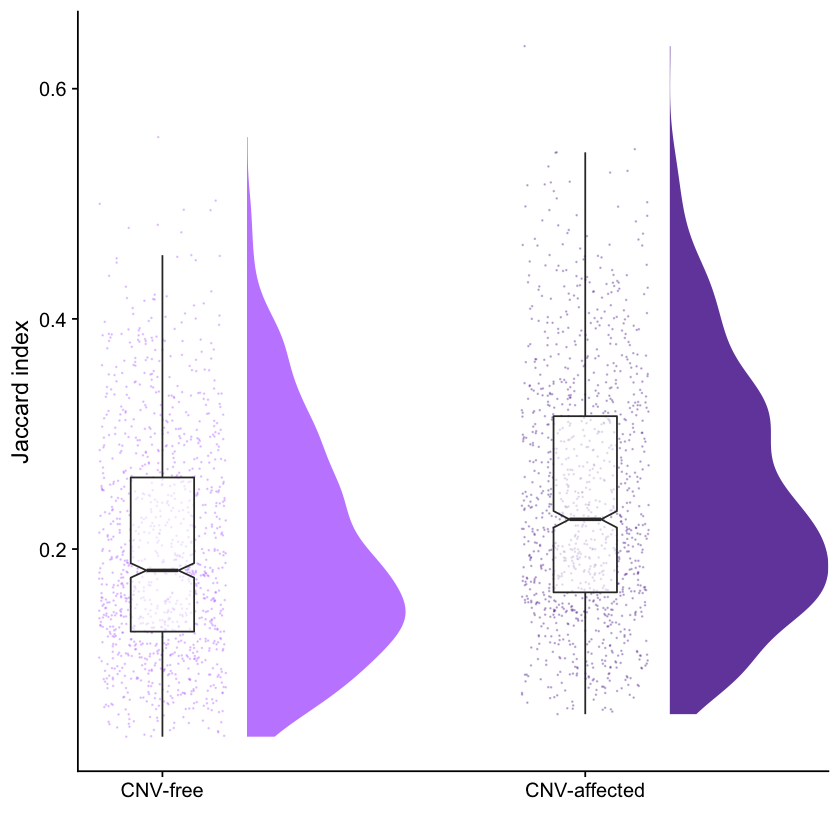

In [19]:
ggplot(mergedForPlotOfJaccardIndex, aes(ExACCNV, value)) +
    theme_cowplot() +
    geom_flat_violin(aes(fill = ExACCNV), position = position_nudge(x = .2, y = 0), alpha = .8, scale="width", width=0.75, color=NA) +
    geom_point(aes(color = ExACCNV), position = position_jitter(width = .15), size = .075, alpha = 0.25) +
    geom_boxplot(notch=TRUE, width = .15, outlier.shape = NA, alpha = 0.6) +
    scale_y_continuous(name="Jaccard index") +
    scale_x_discrete(name="",
        breaks=c("N", "Y"),
        labels=c("CNV-free", "CNV-affected"),
        expand=c(.1,.1)) +
    scale_color_manual(values=c("#b66dff", "#490092"),
        name="",
        breaks=c("N", "Y"),
        labels=c("CNV-free", "CNV-affected")) +
    scale_fill_manual(values=c("#b66dff", "#490092"),
        name="",
        breaks=c("N", "Y"),
        labels=c("CNV-free", "CNV-affected")) +
    theme(legend.position="none")

In [20]:
ggsave("../../outputFiles/figures/eQTLJaccardIndexBonferroniExACCNVRaincloudPlot.svg", plot = last_plot(), width=8, height=10, units="cm")

In [21]:
colnames(melted_jaccardY) <- c("Var2","Var1","value","ExACCNV")
neccessaryForOrder1<-data.frame("Adipose - Subcutaneous","Adipose - Subcutaneous",NA,NA)
names(neccessaryForOrder1)<-c("Var1","Var2","value","ExACCNV")
melted_jaccard <- rbind(neccessaryForOrder1,na.omit(melted_jaccardY), na.omit(melted_jaccardN))

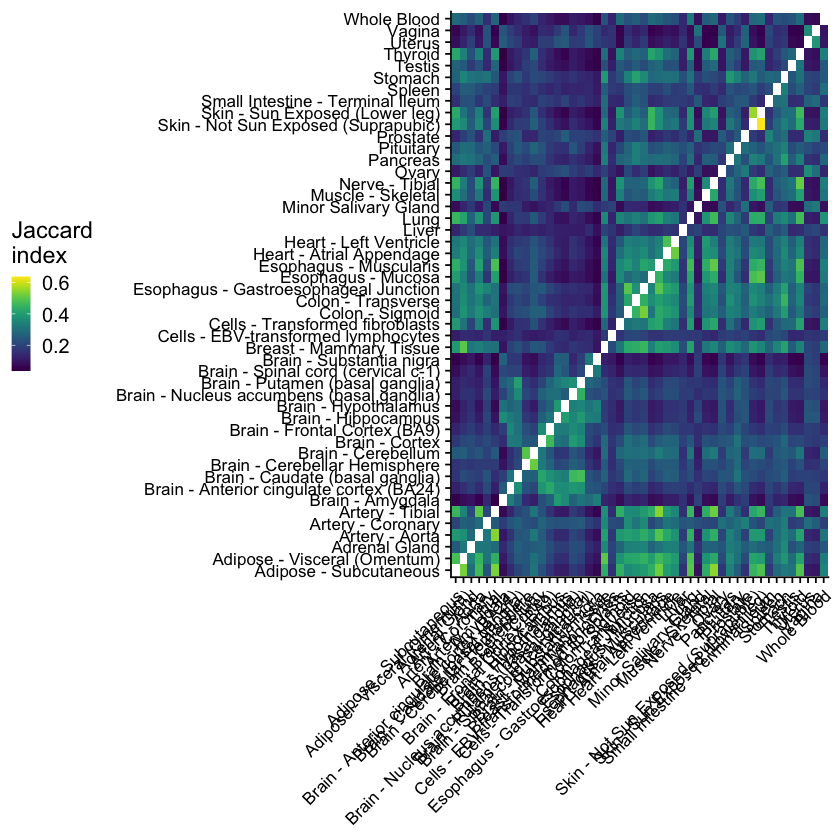

In [22]:
ggplot(data = na.omit(melted_jaccard), aes(x=Var1, y=Var2, fill=value)) + 
    geom_tile() +
    theme_cowplot() +
    scale_fill_viridis("Jaccard\nindex", na.value = 'white',direction = 1) +
    theme(legend.key.size= unit(0.4, "cm"),
          legend.position="left",
          legend.direction = "vertical",
          axis.text.x=element_text(angle = 45, vjust = 1, hjust=1, size = rel(0.85)),
          #axis.text.x=element_blank(),
          #axis.ticks.x=element_blank(),
          axis.title.x=element_blank(),
          axis.text.y=element_text(size = rel(0.85)),
          axis.title.y=element_blank()) +
    scale_y_discrete(limits = rev(levels(melted_jaccard$Var2)))

In [28]:
ggsave('../../outputFiles/figures/eQTLJaccardIndexBonferroniOhnologHeatmap.svg', plot = last_plot(), width = 27, height = 19, units = c("cm"))

---

### Proportion of genes affected by eQTLs per tissue
[Back to top](#Outline)

In [23]:
tissue_list <- c() 
eqtl_list <- c()
ExACCNV_list <- c()
count_list <- c()

for (tissue in c('Adipose - Subcutaneous',
                'Adipose - Visceral (Omentum)',
                'Adrenal Gland',
                'Artery - Aorta',
                'Artery - Coronary',
                'Artery - Tibial',
                'Brain - Amygdala',
                'Brain - Anterior cingulate cortex (BA24)',
                'Brain - Caudate (basal ganglia)',
                'Brain - Cerebellar Hemisphere',
                'Brain - Cerebellum',
                'Brain - Cortex',
                'Brain - Frontal Cortex (BA9)',
                'Brain - Hippocampus',
                'Brain - Hypothalamus',
                'Brain - Nucleus accumbens (basal ganglia)',
                'Brain - Putamen (basal ganglia)',
                'Brain - Spinal cord (cervical c-1)',
                'Brain - Substantia nigra',
                'Breast - Mammary Tissue',
                'Cells - EBV-transformed lymphocytes',
                'Cells - Transformed fibroblasts',
                'Colon - Sigmoid',
                'Colon - Transverse',
                'Esophagus - Gastroesophageal Junction',
                'Esophagus - Mucosa',
                'Esophagus - Muscularis',
                'Heart - Atrial Appendage',
                'Heart - Left Ventricle',
                'Liver',
                'Lung',
                'Minor Salivary Gland',
                'Muscle - Skeletal',
                'Nerve - Tibial',
                'Ovary',
                'Pancreas',
                'Pituitary',
                'Prostate',
                'Skin - Not Sun Exposed (Suprapubic)',
                'Skin - Sun Exposed (Lower leg)',
                'Small Intestine - Terminal Ileum',
                'Spleen',
                'Stomach',
                'Testis',
                'Thyroid',
                'Uterus',
                'Vagina',
                'Whole Blood')){
    
    for (option1 in c('Y',
                'N')){
        
        for (option2 in c('Y',
                'N')){
    
            tissue_list <- c(tissue_list, tissue)
            ExACCNV_list <- c(ExACCNV_list, option1)
            eqtl_list <- c(eqtl_list, option2)
            count_list <- c(count_list, nrow(subset(tested[[tissue]], ExACCNV == option1 & eQTL == option2, select=c(Ensembl.Gene.ID))))
        }
    }
}

In [24]:
eQTLExACCNVCountPerTissue <- data.frame(tissue_list,
                                        ExACCNV_list,
                                        eqtl_list,
                                        count_list)
names(eQTLExACCNVCountPerTissue) <- c('tissue',
                                      'ExACCNV',
                                      'eqtl',
                                      'count')
eQTLExACCNVCountPerTissue

tissue,ExACCNV,eqtl,count
<chr>,<chr>,<chr>,<int>
Adipose - Subcutaneous,Y,Y,4276
Adipose - Subcutaneous,Y,N,7682
Adipose - Subcutaneous,N,Y,443
Adipose - Subcutaneous,N,N,1156
Adipose - Visceral (Omentum),Y,Y,2942
Adipose - Visceral (Omentum),Y,N,9073
Adipose - Visceral (Omentum),N,Y,271
Adipose - Visceral (Omentum),N,N,1325
Adrenal Gland,Y,Y,1895


In [25]:
dcast(eQTLExACCNVCountPerTissue, tissue + eqtl ~ ExACCNV)

Using count as value column: use value.var to override.



tissue,eqtl,N,Y
<chr>,<chr>,<int>,<int>
Adipose - Subcutaneous,N,1156,7682
Adipose - Subcutaneous,Y,443,4276
Adipose - Visceral (Omentum),N,1325,9073
Adipose - Visceral (Omentum),Y,271,2942
Adrenal Gland,N,1416,9948
Adrenal Gland,Y,175,1895
Artery - Aorta,N,1258,8596
Artery - Aorta,Y,328,3248
Artery - Coronary,N,1495,10799


In [26]:
dcast(eQTLExACCNVCountPerTissue, tissue ~ eqtl + ExACCNV)

Using count as value column: use value.var to override.



tissue,N_N,N_Y,Y_N,Y_Y
<chr>,<int>,<int>,<int>,<int>
Adipose - Subcutaneous,1156,7682,443,4276
Adipose - Visceral (Omentum),1325,9073,271,2942
Adrenal Gland,1416,9948,175,1895
Artery - Aorta,1258,8596,328,3248
Artery - Coronary,1495,10799,110,1188
Artery - Tibial,1093,7236,488,4491
Brain - Amygdala,1609,11550,28,441
Brain - Anterior cingulate cortex (BA24),1550,11116,82,879
Brain - Caudate (basal ganglia),1511,10690,124,1331


In [27]:
eQTLExACCNVCountPerTissueWide <- dcast(eQTLExACCNVCountPerTissue, tissue + eqtl ~ ExACCNV)
rownames(eQTLExACCNVCountPerTissueWide) <- paste(eQTLExACCNVCountPerTissueWide[,1],eQTLExACCNVCountPerTissueWide[,2])
eQTLExACCNVCountPerTissueWide[,1] <- NULL
eQTLExACCNVCountPerTissueWide[,1] <- NULL
eQTLExACCNVCountPerTissueWide

Using count as value column: use value.var to override.



,N,Y
,<int>,<int>
Adipose - Subcutaneous N,1156,7682
Adipose - Subcutaneous Y,443,4276
Adipose - Visceral (Omentum) N,1325,9073
Adipose - Visceral (Omentum) Y,271,2942
Adrenal Gland N,1416,9948
Adrenal Gland Y,175,1895
Artery - Aorta N,1258,8596
Artery - Aorta Y,328,3248
Artery - Coronary N,1495,10799


In [28]:
Xsq<- chisq.test(eQTLExACCNVCountPerTissueWide)
Xsq
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test

data:  eQTLExACCNVCountPerTissueWide
X-squared = 1172.7, df = 95, p-value < 2.2e-16


,N,Y
Adipose - Subcutaneous N,3.616050,-3.616050
Adipose - Subcutaneous Y,-5.243898,5.243898
Adipose - Visceral (Omentum) N,2.854826,-2.854826
Adipose - Visceral (Omentum) Y,-5.997928,5.997928
Adrenal Gland N,2.046789,-2.046789
Adrenal Gland Y,-4.782369,4.782369
Artery - Aorta N,2.850876,-2.850876
Artery - Aorta Y,-4.960401,4.960401
Artery - Coronary N,1.091230,-1.091230
Artery - Coronary Y,-3.761905,3.761905


In [29]:
summary(eQTLOhnologCountPerTissue)

ERROR: Error in summary(eQTLOhnologCountPerTissue): object 'eQTLOhnologCountPerTissue' not found


In [29]:
eQTLOhnologCountPerTissue <- read.csv("../../outputFiles/eQTLOhnologCountPerTissue.tsv", sep="\t", header=FALSE)
summary(eQTLOhnologCountPerTissue)

Warning message in file(file, "rt"):
“cannot open file '../../outputFiles/eQTLOhnologCountPerTissue.tsv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [30]:
#nonohnolog vs ohnolog
tapply(eQTLExACCNVCountPerTissue$count, eQTLExACCNVCountPerTissue$ExACCNV, summary)

$N
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   28.0   177.2   802.0   803.9  1420.0  1615.0 

$Y
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    356    1911    6054    5983   10097   11749 


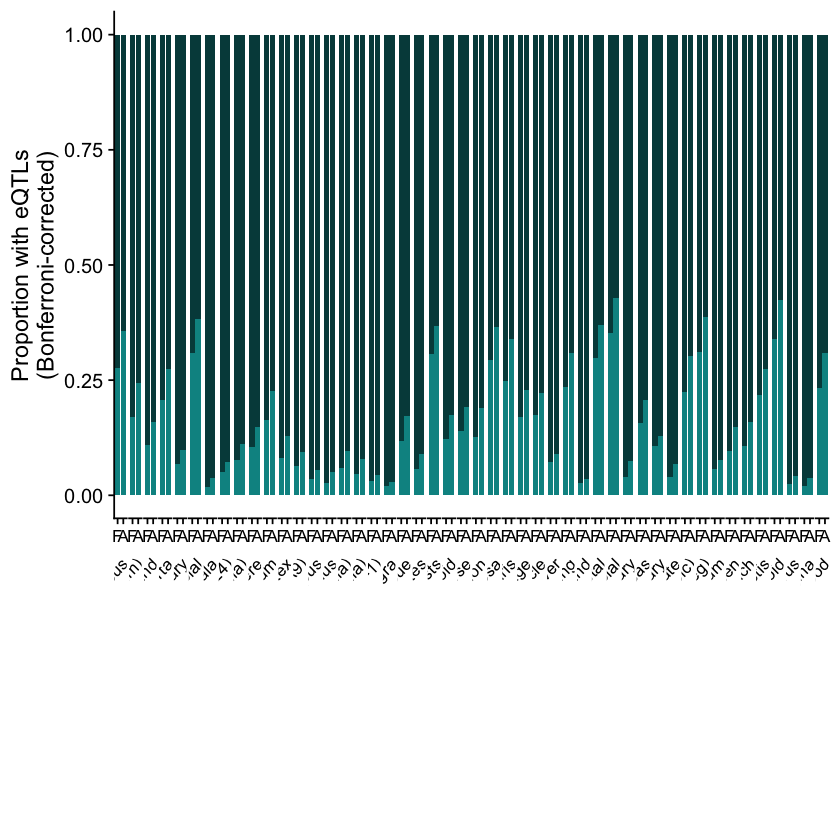

In [31]:
ggplot(eQTLExACCNVCountPerTissue, aes(x=ExACCNV, y=count, fill=factor(eqtl))) +
    theme_cowplot() +
    geom_bar(stat="identity", position="fill") +
    facet_wrap(~tissue, strip.position = "bottom", scales="free_x", nrow=1) +
    theme(strip.placement = "outside", panel.spacing = unit(0.1, 'lines'), strip.background = element_blank(), strip.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = rel(0.85)), axis.text.x = element_text(size = rel(0.85))) +
    scale_y_continuous(name="Proportion with eQTLs\n(Bonferroni-corrected)") +
    scale_x_discrete(name="",
        breaks=c("Y", "N"),
        labels=c("A", "F")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) + 
    theme(legend.position = "none")


In [32]:
ggsave('../../outputFiles/figures/eQTLExACCNVCountPerTissueBonferroni.svg', plot = last_plot(), width = 30, height = 15.5, units = c("cm"))

---

### Proportion of genes affected by eQTLs per tissue grouped by expression level

In [33]:
medianExpressionValues <- read.csv('../../datasets/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct',
                                  sep='\t',
                                  skip=2,
                                  check.names=FALSE)

In [34]:
medianExpressionValues['Ensembl Gene ID'] <- str_extract(medianExpressionValues$gene_id, regex("ENSG\\d+"))

In [35]:
medianExpressionValues

gene_id,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,⋯,Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood,Ensembl Gene ID
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000223972.4,DDX11L1,0.056945,0.05054,0.074600,0.03976,0.04386,0.04977,0.05878,0.089315,⋯,0.05982,0.06089,0.070250,0.063895,1.76000,0.058350,0.03849,0.03386,0.11750,ENSG00000223972
ENSG00000227232.4,WASH7P,11.850000,9.75300,8.023000,12.51000,12.30000,11.59000,14.24000,5.743000,⋯,17.74000,12.19000,18.130000,9.342500,17.14000,19.255000,21.81000,17.28000,8.43900,ENSG00000227232
ENSG00000243485.2,MIR1302-11,0.061460,0.05959,0.081790,0.04297,0.05848,0.05184,0.06097,0.115450,⋯,0.06389,0.05562,0.049525,0.078575,0.07375,0.066845,0.00000,0.04732,0.00000,ENSG00000243485
ENSG00000237613.2,FAM138A,0.038600,0.03245,0.040500,0.02815,0.03678,0.03894,0.04113,0.056265,⋯,0.04080,0.03527,0.032320,0.043800,0.03714,0.038565,0.00000,0.00000,0.02574,ENSG00000237613
ENSG00000268020.2,OR4G4P,0.035695,0.00000,0.034790,0.00000,0.00000,0.00000,0.00000,0.050520,⋯,0.03705,0.03375,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,ENSG00000268020
ENSG00000240361.1,OR4G11P,0.042680,0.03988,0.049065,0.03399,0.00000,0.04286,0.00000,0.062955,⋯,0.04422,0.03869,0.000000,0.050965,0.05081,0.040485,0.04150,0.00000,0.00000,ENSG00000240361
ENSG00000186092.4,OR4F5,0.051450,0.04558,0.061360,0.00000,0.04069,0.04669,0.05461,0.097705,⋯,0.04955,0.05122,0.040025,0.055415,0.03954,0.051925,0.00000,0.00000,0.00000,ENSG00000186092
ENSG00000238009.2,RP11-34P13.7,0.162500,0.12020,0.087785,0.13510,0.13690,0.14720,0.14300,0.070360,⋯,0.13920,0.09105,0.197200,0.087645,0.46710,0.170550,0.16260,0.12560,0.16390,ENSG00000238009
ENSG00000233750.3,CICP27,0.124400,0.13470,0.148800,0.10260,0.11950,0.11450,0.07610,0.166150,⋯,0.13600,0.15480,0.597700,0.149700,0.36590,0.178950,0.14490,0.16240,1.16800,ENSG00000233750


In [36]:
genesWithExpressionLevel <- data.frame("Ensembl Gene ID"=character(),
                                        "median expr"=double(),
                                        "tissue"=factor(),
                                        "ohnolog"=factor(),
                                        "affected"=factor(),
                                         stringsAsFactors=FALSE)

for (tissue in c('Adipose - Subcutaneous',
                'Adipose - Visceral (Omentum)',
                'Adrenal Gland',
                'Artery - Aorta',
                'Artery - Coronary',
                'Artery - Tibial',
                'Brain - Amygdala',
                'Brain - Anterior cingulate cortex (BA24)',
                'Brain - Caudate (basal ganglia)',
                'Brain - Cerebellar Hemisphere',
                'Brain - Cerebellum',
                'Brain - Cortex',
                'Brain - Frontal Cortex (BA9)',
                'Brain - Hippocampus',
                'Brain - Hypothalamus',
                'Brain - Nucleus accumbens (basal ganglia)',
                'Brain - Putamen (basal ganglia)',
                'Brain - Spinal cord (cervical c-1)',
                'Brain - Substantia nigra',
                'Breast - Mammary Tissue',
                'Cells - EBV-transformed lymphocytes',
                'Cells - Transformed fibroblasts',
                'Colon - Sigmoid',
                'Colon - Transverse',
                'Esophagus - Gastroesophageal Junction',
                'Esophagus - Mucosa',
                'Esophagus - Muscularis',
                'Heart - Atrial Appendage',
                'Heart - Left Ventricle',
                'Liver',
                'Lung',
                'Minor Salivary Gland',
                'Muscle - Skeletal',
                'Nerve - Tibial',
                'Ovary',
                'Pancreas',
                'Pituitary',
                'Prostate',
                'Skin - Not Sun Exposed (Suprapubic)',
                'Skin - Sun Exposed (Lower leg)',
                'Small Intestine - Terminal Ileum',
                'Spleen',
                'Stomach',
                'Testis',
                'Thyroid',
                'Uterus',
                'Vagina',
                'Whole Blood')){
    
    for (option1 in c('Y',
                'N')){
        
        for (option2 in c('Y',
                'N')){
            
            gene_list <- subset(tested[[tissue]], ohnolog == option1 & eQTL == option2, select=c(Ensembl.Gene.ID))
            names(gene_list)[names(gene_list) == "Ensembl.Gene.ID"] <- "Ensembl Gene ID"
            gene_list$tissue <- tissue
            gene_list$ohnolog <- option1
            gene_list$affected <- option2
    
            
            expressionLevelForTissue <- subset(medianExpressionValues, select=c("Ensembl Gene ID", tissue))
            names(expressionLevelForTissue)[names(expressionLevelForTissue) == tissue] <- "median expr"
            
            gene_list <- merge(gene_list,expressionLevelForTissue,by="Ensembl Gene ID")
            
            genesWithExpressionLevel <- rbind(genesWithExpressionLevel, gene_list)
        }
    }
}

In [37]:
genesWithExpressionLevel

Ensembl Gene ID,tissue,ohnolog,affected,median expr
<chr>,<chr>,<chr>,<chr>,<dbl>
ENSG00000000003,Adipose - Subcutaneous,Y,Y,39.71000
ENSG00000000938,Adipose - Subcutaneous,Y,Y,29.24000
ENSG00000001461,Adipose - Subcutaneous,Y,Y,3.07800
ENSG00000002746,Adipose - Subcutaneous,Y,Y,0.14500
ENSG00000003137,Adipose - Subcutaneous,Y,Y,35.50500
ENSG00000003987,Adipose - Subcutaneous,Y,Y,1.34750
ENSG00000004534,Adipose - Subcutaneous,Y,Y,77.30500
ENSG00000004777,Adipose - Subcutaneous,Y,Y,12.73000
ENSG00000004799,Adipose - Subcutaneous,Y,Y,614.10000


In [38]:
genesWithExpressionLevel$tissue <- as.factor(genesWithExpressionLevel$tissue)
genesWithExpressionLevel$affected <- as.factor(genesWithExpressionLevel$affected)
genesWithExpressionLevel$ohnolog <- as.factor(genesWithExpressionLevel$ohnolog)

In [39]:
summary(genesWithExpressionLevel)

 Ensembl Gene ID                                 tissue       ohnolog   
 Length:790141      Testis                          : 18589   N:505070  
 Class :character   Pituitary                       : 17184   Y:285071  
 Mode  :character   Prostate                        : 17039             
                    Small Intestine - Terminal Ileum: 16972             
                    Lung                            : 16906             
                    Brain - Hypothalamus            : 16892             
                    (Other)                         :686559             
 affected    median expr       
 N:643917   Min.   :     0.00  
 Y:146224   1st Qu.:     1.65  
            Median :     8.26  
            Mean   :    33.45  
            3rd Qu.:    24.50  
            Max.   :246600.00  
                               

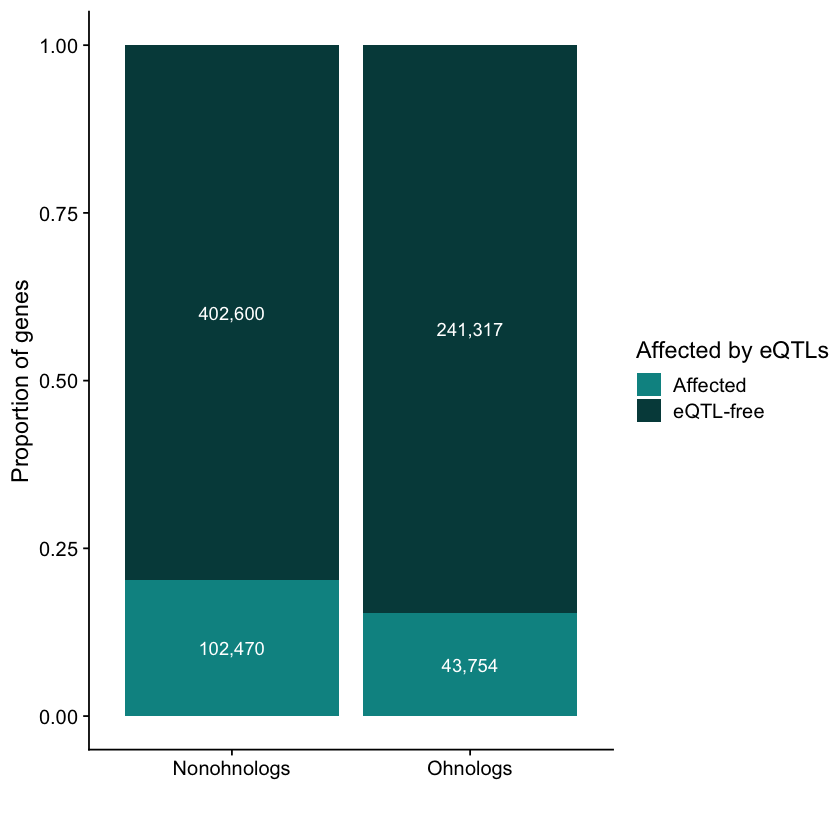

In [40]:
ggplot(genesWithExpressionLevel, aes(x=ohnolog)) +
geom_bar(aes(fill=affected), position = "fill") +
scale_y_continuous(name="Proportion of genes") +
scale_x_discrete(name="",
    breaks=c('Y', 'N'),
    labels=c("Ohnologs\n", "Nonohnologs")) +
scale_fill_manual(values=c("#009292", "#004949"),
    name="Affected by eQTLs",
    breaks=c('Y', 'N'),
    labels=c("Affected", "eQTL-free")) + 
geom_text(aes(label = prettyNum(..count.., big.mark=","),
               group=affected),
          vjust=0.5,
          stat='count',
          colour = "white",
          position = position_fill(vjust = .5)) +
theme_cowplot()

In [41]:
genesWithExpressionLevel$bins <- as.numeric(cut2(genesWithExpressionLevel$"median expr", g=10))

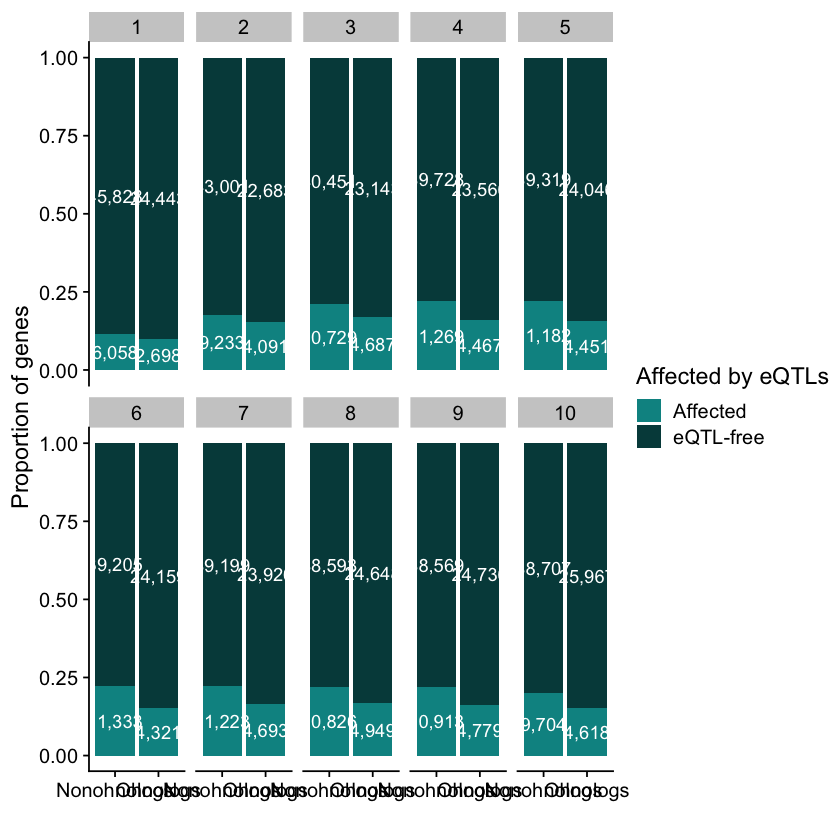

In [42]:
ggplot(genesWithExpressionLevel, aes(x=ohnolog)) +
geom_bar(aes(fill=affected), position = "fill") +
scale_y_continuous(name="Proportion of genes") +
scale_x_discrete(name="",
    breaks=c('Y', 'N'),
    labels=c("Ohnologs", "Nonohnologs")) +
scale_fill_manual(values=c("#009292", "#004949"),
    name="Affected by eQTLs",
    breaks=c('Y', 'N'),
    labels=c("Affected", "eQTL-free")) + 
geom_text(aes(label = prettyNum(..count.., big.mark=","),
               group=affected),
          vjust=0.5,
          stat='count',
          colour = "white",
          position = position_fill(vjust = .5)) +
theme_cowplot() + facet_wrap(~bins, nrow = 2)

In [44]:
#nonohnolog vs ohnolog
tapply(genesWithExpressionLevel$"median expr", genesWithExpressionLevel$bins, summary)

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.07819 0.12555 0.13601 0.18925 0.27740 

$`2`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2774  0.3944  0.5482  0.5781  0.7470  0.9968 

$`3`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9969  1.2975  1.6540  1.6917  2.0680  2.5325 

$`4`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.533   3.054   3.626   3.662   4.252   4.940 

$`5`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.941   5.684   6.479   6.520   7.340   8.264 

$`6`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  8.265   9.265  10.350  10.411  11.520  12.820 

$`7`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.82   14.26   15.84   15.96   17.60   19.57 

$`8`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.57   21.84   24.51   24.83   27.66   31.35 

$`9`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  31.36   35.84   41.38   42.61   48.73   58.97 

$`10`
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max

In [51]:
expression_level_labels <- c(
  `1` = "0 - 0.28 TPM",
  `2` = "0.28 - 1.00 TPM",
  `3` = "1.00 - 2.53 TPM",
  `4` = "2.53 - 4.94 TPM",
  `5` = "4.94 - 8.26 TPM",
  `6` = "8.27 - 12.82 TPM",
  `7` = "12.82 - 19.57 TPM",
  `8` = "19.57 - 31.35 TPM", 
  `9` = "31.36 - 58.97 TPM",
  `10` = "58.98 - 246,600 TPM"
)

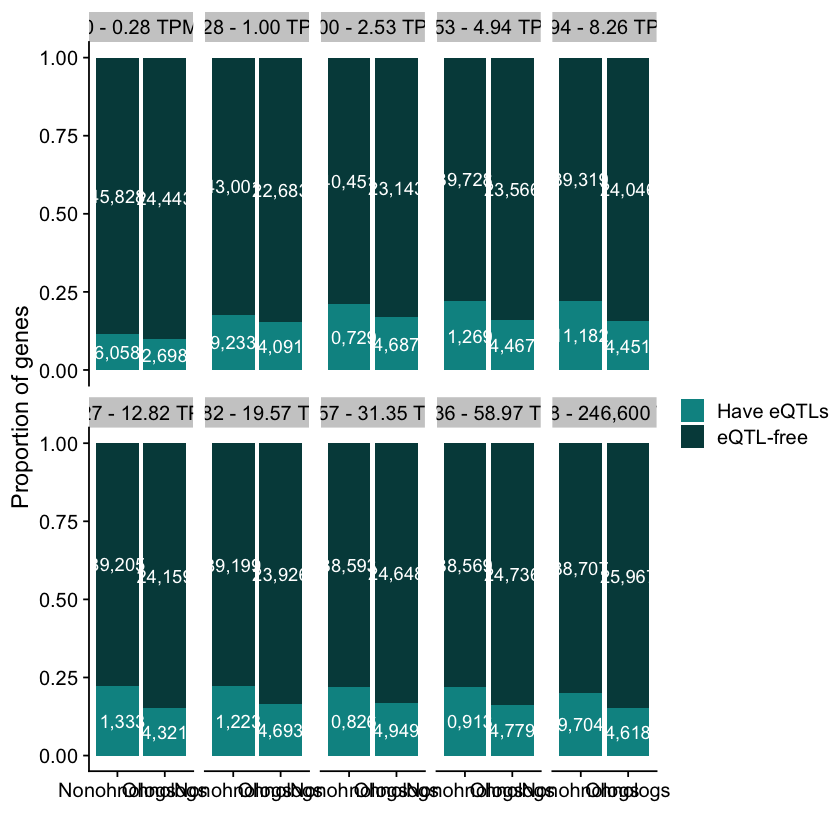

In [56]:
ggplot(genesWithExpressionLevel, aes(x=ohnolog)) +
geom_bar(aes(fill=affected), position = "fill") +
scale_y_continuous(name="Proportion of genes") +
scale_x_discrete(name="",
    breaks=c('Y', 'N'),
    labels=c("Ohnologs", "Nonohnologs")) +
scale_fill_manual(values=c("#009292", "#004949"),
    name="",
    breaks=c('Y', 'N'),
    labels=c("Have eQTLs", "eQTL-free")) + 
geom_text(aes(label = prettyNum(..count.., big.mark=","),
               group=affected),
          vjust=0.5,
          stat='count',
          colour = "white",
          position = position_fill(vjust = .5)) +
theme_cowplot() + facet_wrap(~bins, nrow = 2,, labeller = as_labeller(expression_level_labels))

In [58]:
ggsave('../../outputFiles/figures/eQTLOhnologCountBonferroniExpressionLevel.svg', plot = last_plot(), width = 32, height = 15.5, units = c("cm"))

In [116]:
table(genesWithExpressionLevel[,c("ohnolog","bins", "affected")])

, , affected = N

       bins
ohnolog     1     2     3     4     5     6     7     8     9    10
      N 23640 17648 13824 12230 11590 11246 11656 11791 12483 13254
      Y 14086 10440  9546  9152  9114  8859  8569  8711  9229 10928

, , affected = Y

       bins
ohnolog     1     2     3     4     5     6     7     8     9    10
      N 28246 34586 37356 38767 38911 39292 38766 37628 36999 35157
      Y 13055 16334 18284 18881 19383 19621 20050 20886 20286 19657


In [117]:
(Xsq <- chisq.test(table(genesWithExpressionLevel[,c("ohnolog","bins")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test

data:  table(genesWithExpressionLevel[, c("ohnolog", "bins")])
X-squared = 665.87, df = 9, p-value < 2.2e-16


       bins
ohnolog     1     2     3     4     5     6     7     8     9    10
      N 51886 52234 51180 50997 50501 50538 50422 49419 49482 48411
      Y 27141 26774 27830 28033 28497 28480 28619 29597 29515 30585

,1,2,3,4,5,6,7,8,9,10
N,50515.25,50503.1,50504.38,50517.16,50496.71,50509.49,50524.19,50508.21,50496.07,50495.43
Y,28511.75,28504.9,28505.62,28512.84,28501.29,28508.51,28516.81,28507.79,28500.93,28500.57


       bins
ohnolog            1            2            3            4            5
      N  10.70303116  13.51653646   5.27584167   3.74656408   0.03351299
      Y -10.70303116 -13.51653646  -5.27584167  -3.74656408  -0.03351299
       bins
ohnolog            6            7            8            9           10
      N   0.22259821  -0.79788848  -8.50525843  -7.91932568 -16.27834759
      Y  -0.22259821   0.79788848   8.50525843   7.91932568  16.27834759

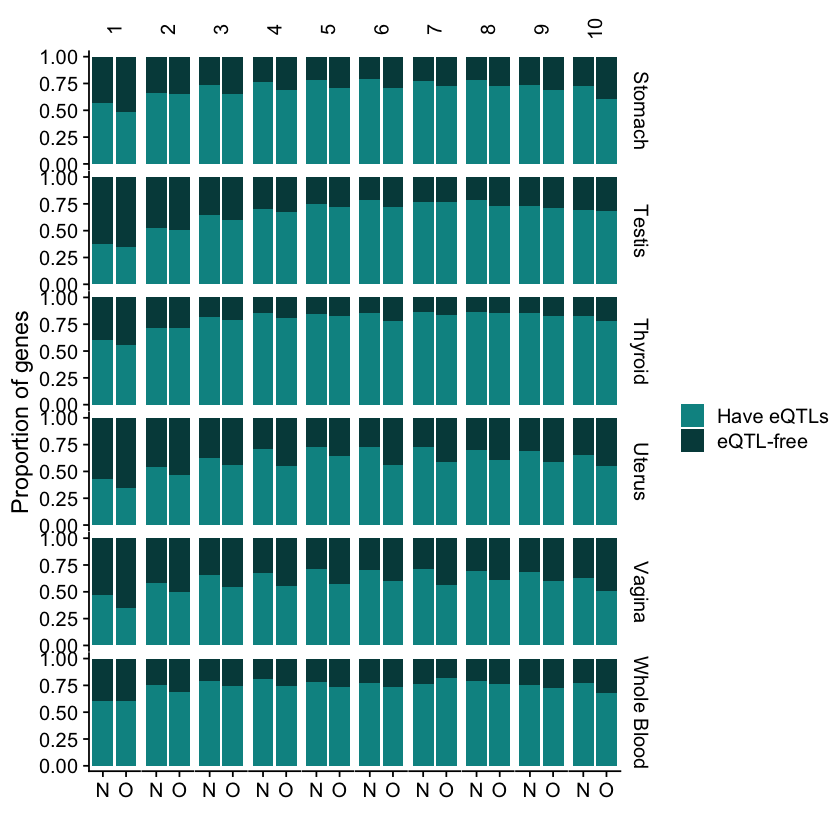

In [121]:
ggplot(genesWithExpressionLevel, aes(x=ohnolog, fill=factor(affected))) +
    geom_bar(position="fill") +
    #facet_wrap(tissue ~ bins, ncol = 10) +
    facet_grid_paginate(tissue ~ bins, ncol = 10, nrow = 6, page = 8) +
    theme_cowplot() +
    theme(strip.placement = "outside", panel.spacing = unit(0.1, 'lines'), strip.background = element_blank(), strip.text.x = element_text(angle = 90, vjust = 0.5)) +
    scale_y_continuous(name="Proportion of genes") +
    scale_x_discrete(name="",
        breaks=c("Y", "N"),
        labels=c("O", "N")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) 

In [115]:
ggsave('../../outputFiles/figures/eQTLOhnologCountPerTissueBonferroni.svg', plot = last_plot(), width = 30, height = 15.5, units = c("cm"))

---

#### Metasoft eQTLs

In [29]:
eQTLs = list()
tested = list()
forJaccardY = list()
forJaccardN = list()

for (tissue in c('Adipose - Subcutaneous',
                'Adipose - Visceral (Omentum)',
                'Adrenal Gland',
                'Artery - Aorta',
                'Artery - Coronary',
                'Artery - Tibial',
                'Brain - Amygdala',
                'Brain - Anterior cingulate cortex (BA24)',
                'Brain - Caudate (basal ganglia)',
                'Brain - Cerebellar Hemisphere',
                'Brain - Cerebellum',
                'Brain - Cortex',
                'Brain - Frontal Cortex (BA9)',
                'Brain - Hippocampus',
                'Brain - Hypothalamus',
                'Brain - Nucleus accumbens (basal ganglia)',
                'Brain - Putamen (basal ganglia)',
                'Brain - Spinal cord (cervical c-1)',
                'Brain - Substantia nigra',
                'Breast - Mammary Tissue',
                'Cells - EBV-transformed lymphocytes',
                'Cells - Transformed fibroblasts',
                'Colon - Sigmoid',
                'Colon - Transverse',
                'Esophagus - Gastroesophageal Junction',
                'Esophagus - Mucosa',
                'Esophagus - Muscularis',
                'Heart - Atrial Appendage',
                'Heart - Left Ventricle',
                'Liver',
                'Lung',
                'Minor Salivary Gland',
                'Muscle - Skeletal',
                'Nerve - Tibial',
                'Ovary',
                'Pancreas',
                'Pituitary',
                'Prostate',
                'Skin - Not Sun Exposed (Suprapubic)',
                'Skin - Sun Exposed (Lower leg)',
                'Small Intestine - Terminal Ileum',
                'Spleen',
                'Stomach',
                'Testis',
                'Thyroid',
                'Uterus',
                'Vagina',
                'Whole Blood')){
    eQTLs[[tissue]] <- read.table(paste0("../../outputFiles/GTExV7/GTExAffectedGenes/Metasoft/", tissue, ".txt"))
    colnames(eQTLs[[tissue]]) <- c('Ensembl.Gene.ID')
    eQTLs[[tissue]] <- merge(eQTLs[[tissue]],PCGenes,by="Ensembl.Gene.ID")
    
    tested[[tissue]] <- read.table(paste0("../../outputFiles/GTExV7/GTExTestedGenes/", tissue, ".txt"))
    colnames(tested[[tissue]]) <- c('Ensembl.Gene.ID')
    tested[[tissue]] <- merge(tested[[tissue]],PCGenes,by="Ensembl.Gene.ID")
    
    tested[[tissue]]$eQTL[tested[[tissue]]$Ensembl.Gene.ID %in% eQTLs[[tissue]]$Ensembl.Gene.ID] <- 'Y'
    tested[[tissue]]$eQTL[!tested[[tissue]]$Ensembl.Gene.ID %in% eQTLs[[tissue]]$Ensembl.Gene.ID] <- 'N'
    
    tested[[tissue]]$ohnolog[tested[[tissue]]$Ensembl.Gene.ID %in% ohnologs$Ensembl.Gene.ID] <- 'Y'
    tested[[tissue]]$ohnolog[tested[[tissue]]$Ensembl.Gene.ID %in% nonohnolog$Ensembl.Gene.ID] <- 'N'
    
    forJaccardY[[tissue]] <- subset(tested[[tissue]], ohnolog == 'Y' & eQTL == 'Y', select=c(Ensembl.Gene.ID))$Ensembl.Gene.ID
    forJaccardN[[tissue]] <- subset(tested[[tissue]], ohnolog == 'N' & eQTL == 'Y', select=c(Ensembl.Gene.ID))$Ensembl.Gene.ID
}

In [30]:
goY <- newGOM(forJaccardY, genome.size=15738)
goN <- newGOM(forJaccardN, genome.size=15738)

In [31]:
jaccardY <- getMatrix(goY, "Jaccard")
jaccardN <- getMatrix(goN, "Jaccard")

In [32]:
jaccardY

,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,⋯,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Adipose - Subcutaneous,0.7864783,0.7014044,0.7616384,0.7231627,0.7792106,0.6128832,0.6366775,0.6614032,0.6560878,0.6774068,⋯,0.7515528,0.7603607,0.6806637,0.6958299,0.7186495,0.6956936,0.7700820,0.6478398,0.6511872,0.6502908
Adipose - Visceral (Omentum),0.0000000,0.7113598,0.7692149,0.7248508,0.7514840,0.6248921,0.6417753,0.6631579,0.6495078,0.6772636,⋯,0.7376659,0.7366167,0.6838204,0.7070686,0.7187241,0.6796192,0.7486434,0.6611770,0.6606246,0.6516877
Adrenal Gland,0.0000000,0.0000000,0.7122852,0.6960500,0.6866425,0.6356877,0.6516829,0.6655658,0.6593407,0.6574387,⋯,0.6789047,0.6805583,0.6785955,0.6983127,0.6937934,0.6640131,0.6911182,0.6683180,0.6556461,0.6302832
Artery - Aorta,0.0000000,0.0000000,0.0000000,0.7502172,0.7898904,0.6346196,0.6496815,0.6788031,0.6679858,0.6854822,⋯,0.7362353,0.7382629,0.6824655,0.7018066,0.7185940,0.6882353,0.7482980,0.6692529,0.6573243,0.6481943
Artery - Coronary,0.0000000,0.0000000,0.0000000,0.0000000,0.7213859,0.6466729,0.6594681,0.6688025,0.6636504,0.6651074,⋯,0.7044751,0.6919984,0.6789177,0.6929470,0.6978214,0.6608855,0.6995211,0.6906130,0.6822275,0.6326486
Artery - Tibial,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.6062294,0.6360130,0.6590818,0.6584050,0.6767519,⋯,0.7373893,0.7456240,0.6616039,0.6762982,0.7018905,0.6835036,0.7620133,0.6416124,0.6272520,0.6526104
Brain - Amygdala,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.6985887,0.6903553,0.6590585,0.6461399,⋯,0.6119247,0.6042475,0.6309806,0.6447430,0.6371661,0.6011829,0.6031426,0.6611296,0.6339330,0.5756954
Brain - Anterior cingulate cortex (BA24),0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.7086077,0.6743649,0.6754776,⋯,0.6322897,0.6275531,0.6394869,0.6497497,0.6487258,0.6196370,0.6316416,0.6537241,0.6376533,0.5867020
Brain - Caudate (basal ganglia),0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.6762735,0.6841650,⋯,0.6572694,0.6543624,0.6454263,0.6619406,0.6601755,0.6510491,0.6620298,0.6498356,0.6287757,0.5960507
Brain - Cerebellar Hemisphere,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.7672042,⋯,0.6489362,0.6520537,0.6420959,0.6509372,0.6477974,0.6340133,0.6613694,0.6401497,0.6197151,0.5969443


In [33]:
jaccardN[jaccardN == 0] <- NA
jaccardY[jaccardY == 0] <- NA
melted_jaccardY <- melt(jaccardY)
melted_jaccardN <- melt(jaccardN)

In [34]:
melted_jaccardY

Var1,Var2,value
<fct>,<fct>,<dbl>
Adipose - Subcutaneous,Adipose - Visceral (Omentum),0.7864783
Adipose - Visceral (Omentum),Adipose - Visceral (Omentum),NA
Adrenal Gland,Adipose - Visceral (Omentum),NA
Artery - Aorta,Adipose - Visceral (Omentum),NA
Artery - Coronary,Adipose - Visceral (Omentum),NA
Artery - Tibial,Adipose - Visceral (Omentum),NA
Brain - Amygdala,Adipose - Visceral (Omentum),NA
Brain - Anterior cingulate cortex (BA24),Adipose - Visceral (Omentum),NA
Brain - Caudate (basal ganglia),Adipose - Visceral (Omentum),NA


In [35]:
na.omit(melted_jaccardY[order(melted_jaccardY$value),])

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1525,Cells - EBV-transformed lymphocytes,Nerve - Tibial,0.5452160
1995,Cells - EBV-transformed lymphocytes,Testis,0.5519536
1807,Cells - EBV-transformed lymphocytes,Skin - Sun Exposed (Lower leg),0.5541520
899,Artery - Tibial,Cells - EBV-transformed lymphocytes,0.5559741
2042,Cells - EBV-transformed lymphocytes,Thyroid,0.5565787
894,Adipose - Subcutaneous,Cells - EBV-transformed lymphocytes,0.5634987
1149,Cells - EBV-transformed lymphocytes,Esophagus - Mucosa,0.5635900
1478,Cells - EBV-transformed lymphocytes,Muscle - Skeletal,0.5652460
2180,Brain - Spinal cord (cervical c-1),Whole Blood,0.5662706


In [36]:
wilcox.test(na.omit(melted_jaccardY)$value, na.omit(melted_jaccardN)$value)


	Wilcoxon rank sum test with continuity correction

data:  na.omit(melted_jaccardY)$value and na.omit(melted_jaccardN)$value
W = 102847, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [37]:
summary(na.omit(melted_jaccardY)$value)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5452  0.6391  0.6593  0.6654  0.6913  0.8121 

In [38]:
summary(na.omit(melted_jaccardN)$value)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6344  0.7231  0.7437  0.7444  0.7679  0.8558 

In [39]:
melted_jaccardY$ohnolog <- 'Y'
melted_jaccardN$ohnolog <- 'N'
mergedForPlotOfJaccardIndex <- rbind(na.omit(melted_jaccardY),na.omit(melted_jaccardN))
mergedForPlotOfJaccardIndex

,Var1,Var2,value,ohnolog
,<fct>,<fct>,<dbl>,<chr>
1,Adipose - Subcutaneous,Adipose - Visceral (Omentum),0.7864783,Y
48,Adipose - Subcutaneous,Adrenal Gland,0.7014044,Y
49,Adipose - Visceral (Omentum),Adrenal Gland,0.7113598,Y
95,Adipose - Subcutaneous,Artery - Aorta,0.7616384,Y
96,Adipose - Visceral (Omentum),Artery - Aorta,0.7692149,Y
97,Adrenal Gland,Artery - Aorta,0.7122852,Y
142,Adipose - Subcutaneous,Artery - Coronary,0.7231627,Y
143,Adipose - Visceral (Omentum),Artery - Coronary,0.7248508,Y
144,Adrenal Gland,Artery - Coronary,0.6960500,Y


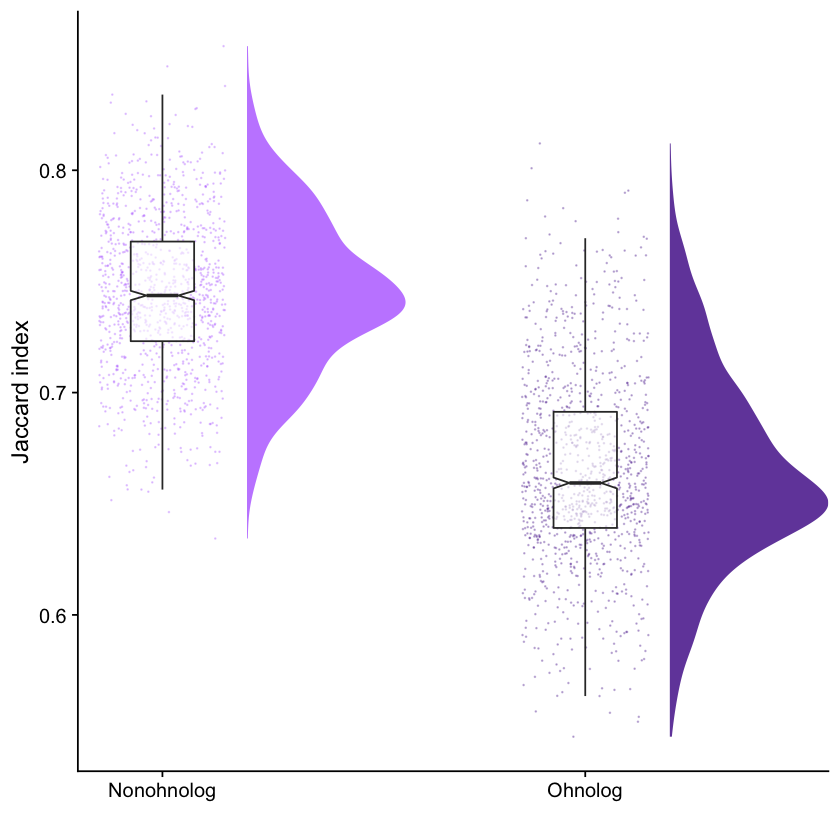

In [40]:
eQTLJaccardIndexMetasoftOhnologRaincloudPlot <- ggplot(mergedForPlotOfJaccardIndex, aes(ohnolog, value)) +
    theme_cowplot() +
    geom_flat_violin(aes(fill = ohnolog), position = position_nudge(x = .2, y = 0), alpha = .8, scale="width", width=0.75, color=NA) +
    geom_point(aes(color = ohnolog), position = position_jitter(width = .15), size = .075, alpha = 0.25) +
    geom_boxplot(notch=TRUE, width = .15, outlier.shape = NA, alpha = 0.6) +
    scale_y_continuous(name="Jaccard index") +
    scale_x_discrete(name="",
        breaks=c("N", "Y"),
        labels=c("Nonohnolog", "Ohnolog"),
        expand=c(.1,.1)) +
    scale_color_manual(values=c("#b66dff", "#490092"),
        name="",
        breaks=c("N", "Y"),
        labels=c("Nonohnolog", "Ohnolog")) +
    scale_fill_manual(values=c("#b66dff", "#490092"),
        name="",
        breaks=c("N", "Y"),
        labels=c("Nonohnolog", "Ohnolog")) +
    theme(legend.position="none")
eQTLJaccardIndexMetasoftOhnologRaincloudPlot

In [41]:
ggsave("../../outputFiles/figures/eQTLJaccardIndexMetasoftOhnologRaincloudPlot.svg", plot = last_plot(), width=8, height=10, units="cm")

In [42]:
colnames(melted_jaccardY) <- c("Var2","Var1","value","ohnolog")
neccessaryForOrder1<-data.frame("Adipose - Subcutaneous","Adipose - Subcutaneous",NA,NA)
names(neccessaryForOrder1)<-c("Var1","Var2","value","ohnolog")
melted_jaccard <- rbind(neccessaryForOrder1,na.omit(melted_jaccardY), na.omit(melted_jaccardN))

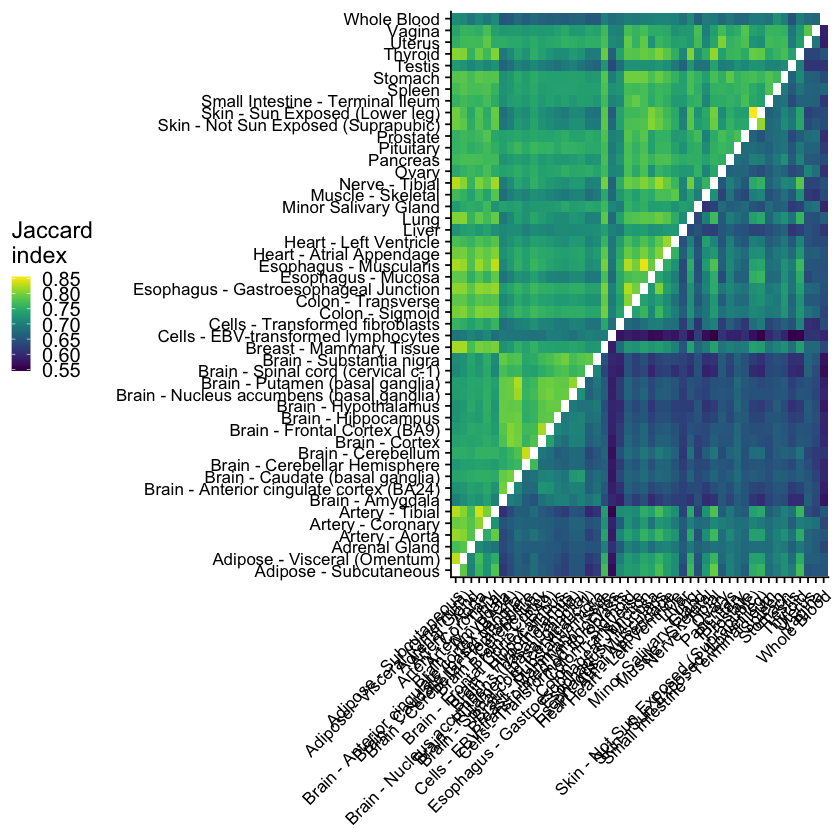

In [43]:
eQTLJaccardIndexMetasoftOhnologHeatmap <- ggplot(data = na.omit(melted_jaccard), aes(x=Var1, y=Var2, fill=value)) + 
    geom_tile() +
    theme_cowplot() +
    scale_fill_viridis("Jaccard\nindex", na.value = 'white',direction = 1) +
    theme(legend.key.size= unit(0.4, "cm"),
          legend.position="left",
          legend.direction = "vertical",
          axis.text.x=element_text(angle = 45, vjust = 1, hjust=1, size = rel(0.85)),
          #axis.text.x=element_blank(),
          #axis.ticks.x=element_blank(),
          axis.title.x=element_blank(),
          axis.text.y=element_text(size = rel(0.85)),
          axis.title.y=element_blank()) +
    scale_y_discrete(limits = rev(levels(melted_jaccard$Var2)))
eQTLJaccardIndexMetasoftOhnologHeatmap

In [44]:
ggsave('../../outputFiles/figures/eQTLJaccardIndexMetasoftOhnologHeatmap.svg', plot = last_plot(), width = 24, height = 19, units = c("cm"))

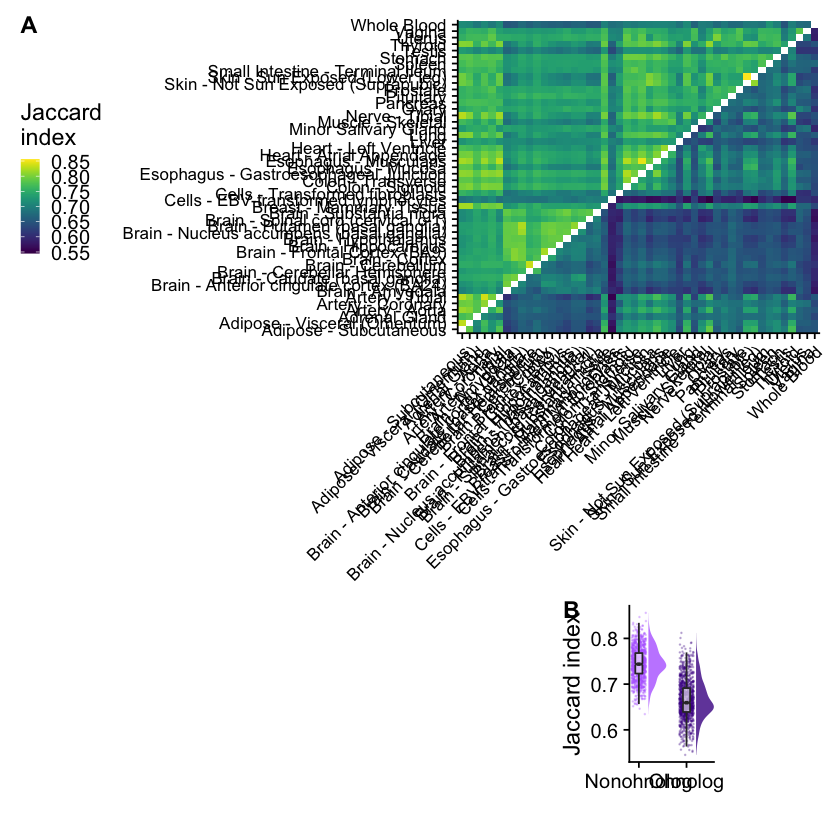

In [73]:
(eQTLJaccardIndexMetasoftOhnologHeatmap) / (plot_spacer() + eQTLJaccardIndexMetasoftOhnologRaincloudPlot + plot_spacer()) + 
  plot_layout(heights = c(2, 1)) + plot_annotation(tag_levels = 'A')

In [76]:
ggsave('../../outputFiles/figures/eQTLJaccardIndexMetasoftOhnologHeatmapAndRaincloudPlot.svg', plot = last_plot(), width = 26, height = 30, units = c("cm"))

---